<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 5: Alzheimer's Image Classification

---
## Problem Statement

You are a data science team that has been tasked by the UK government to develop a diagnostic solution that can improve the prediction rates of dementia and Alzheimer's within UK hospitals. Using a Convolutional Neural Network on brain scan imaging, our group wishes to predict Alzheimer's disease with at least 50% accuracy and a recall of at least 64%. This metric is benchmarked to the average diagnostic performance of hospitals across the UK for patients, and an improvement in detection here can mean better outcomes and care for those within its early stages.

---

In [ ]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# check for GPU connection
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Tensorflow version 2.6.0
Found GPU at: /device:GPU:0


In [ ]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.applications import MobileNetV3Small

## Pretrained Neural Network

### Train and Test Data

In [ ]:
# Create Test and Train 
train_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.33)

# Data Augmentation referenced from "Deep Learning with Python by Francois Chollet: Chapter 5"
train_datagen_aug = ImageDataGenerator(rescale=1.0/255, 
                                   validation_split=0.33,
                                   rotation_range=30,
                                   width_shift_range=0.3,
                                   height_shift_range=0.3,
                                   shear_range=0.3,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_dir = '/content/drive/MyDrive/data/train'
img_width = 176
img_height = 208


train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=64,
    class_mode='categorical',
    subset='training',
    seed=42
)

train_gen_aug = train_datagen_aug.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=64,
    class_mode='categorical',
    subset='training',
    seed=42
)

validation_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=64,
    class_mode='categorical',
    subset='validation',
    seed=42
)

Found 3433 images belonging to 4 classes.
Found 3433 images belonging to 4 classes.
Found 1688 images belonging to 4 classes.


In [ ]:
# number of steps per epoch for training
train_steps = train_gen.samples // train_gen.batch_size
val_steps = validation_gen.samples // validation_gen.batch_size
print(train_steps)
print(val_steps)

53
26


In [ ]:
# display classes
train_gen.class_indices

{'MildDemented': 0,
 'ModerateDemented': 1,
 'NonDemented': 2,
 'VeryMildDemented': 3}

In [ ]:
# check data shape
train_gen.image_shape

(208, 176, 3)

Base line accuracy is 50%

### MobileNetV3

In [ ]:
# instantantiate base model
conv_base = MobileNetV3Small(
    input_shape=(img_width, img_height, 3),
    include_top=False,
    weights='imagenet')
conv_base.trainable = False
conv_base.summary()

6709248/6698480 [==============================] - 0s 0us/step
Model: "MobilenetV3small"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 176, 208, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 176, 208, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 88, 104, 16)  432         rescaling[0][0]                  
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 88, 104, 16)  64          Conv[0][0]                       
____________________

In [ ]:
# Neural Net Architecture
def create_model():
  model = Sequential()
  model.add(conv_base)
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(4, activation='softmax'))
  model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', Precision(), Recall()])
  return model

In [ ]:
# create model
model = create_model()

In [ ]:
# fit and train model
with tf.device('/device:GPU:0'):
  history = model.fit(
      train_gen,
      validation_data=validation_gen,
      epochs=60,
      steps_per_epoch=train_steps,
      validation_steps=val_steps
  )

Epoch 1/60
53/53 [==============================] - 1538s 29s/step - loss: 1.1037 - accuracy: 0.4693 - precision: 0.4819 - recall: 0.2769 - val_loss: 1.0363 - val_accuracy: 0.5018 - val_precision: 0.5018 - val_recall: 0.5018
Epoch 2/60
53/53 [==============================] - 9s 173ms/step - loss: 1.0577 - accuracy: 0.4859 - precision: 0.5154 - recall: 0.2378 - val_loss: 1.0372 - val_accuracy: 0.5012 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/60
53/53 [==============================] - 9s 172ms/step - loss: 1.0548 - accuracy: 0.4960 - precision: 0.4979 - recall: 0.2149 - val_loss: 1.0363 - val_accuracy: 0.4994 - val_precision: 0.4994 - val_recall: 0.4994
Epoch 4/60
53/53 [==============================] - 9s 172ms/step - loss: 1.0526 - accuracy: 0.4883 - precision: 0.4955 - recall: 0.2116 - val_loss: 1.0376 - val_accuracy: 0.5012 - val_precision: 0.9286 - val_recall: 0.0078
Epoch 5/60
53/53 [==============================] - 9s 169ms/step - loss: 1.0488 - accuracy: 0.

In [ ]:
# store accuracy, loss, precision, and recall values
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

prec = history.history['precision']
val_prec = history.history['val_precision']

recall = history.history['recall']
val_recall = history.history['val_recall']

epochs_range = range(60)

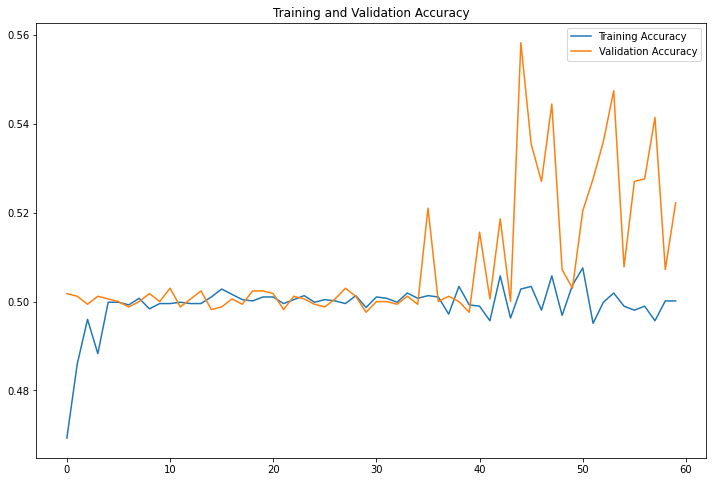

In [ ]:
# plot training and validation accuracy
plt.figure(figsize=(12, 8))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend();

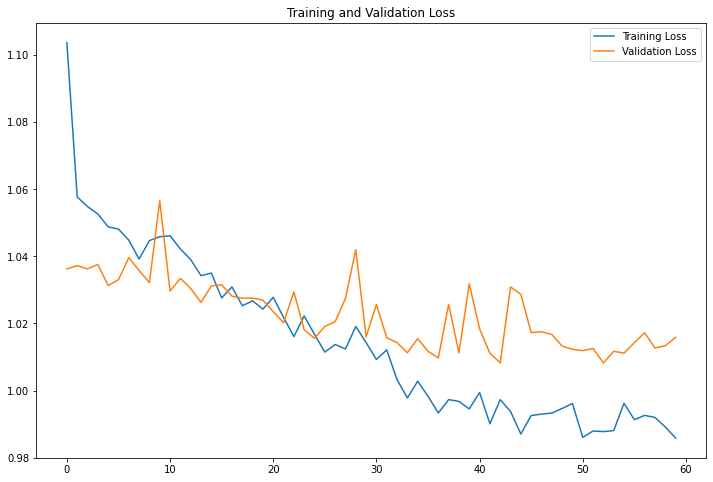

In [ ]:
# plot training and validation loss
plt.figure(figsize=(12, 8))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend();

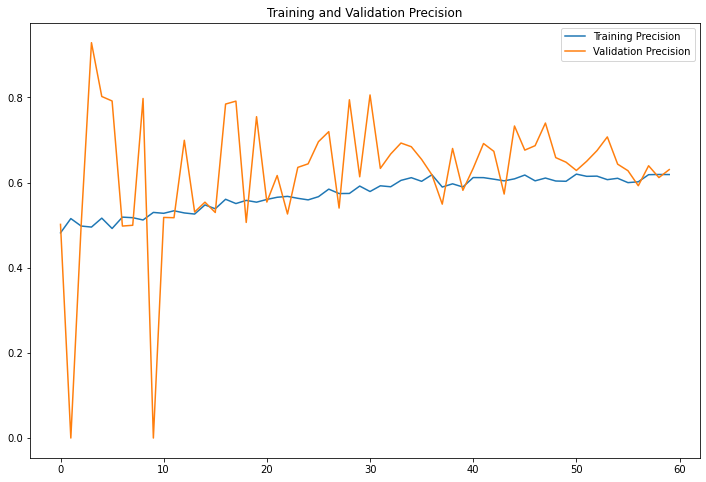

In [ ]:
# plot training and validation precision
plt.figure(figsize=(12, 8))
plt.plot(epochs_range, prec, label='Training Precision')
plt.plot(epochs_range, val_prec, label='Validation Precision')
plt.title('Training and Validation Precision')
plt.legend();

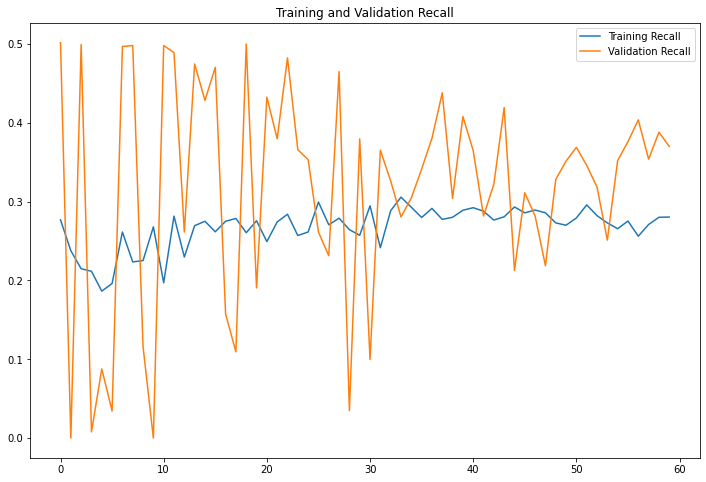

In [ ]:
# plot training and validation recall
plt.figure(figsize=(12, 8))
plt.plot(epochs_range, recall, label='Training Recall')
plt.plot(epochs_range, val_recall, label='Validation Recall')
plt.title('Training and Validation Recall')
plt.legend();

Based on all the charts, MobileNetV3 model is slightly overfit, but less overfit than our fine tuned model and InceptionV3 model without data augmentation. It is performaning better than our baseline model. After about 45 epochs the model stops improving. The best accuracy is about 56%, the best precision is about 73% and best recall score is about 21%.

### MobileNetV3 with Data Augmentation

In [ ]:
# create model
model_aug = create_model()
model_aug.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
MobilenetV3small (Functional (None, 1, 1, 1024)        1529968   
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               262400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 1028      
Total params: 1,793,396
Trainable params: 263,428
Non-trainable params: 1,529,968
_________________________________________________________________


In [ ]:
# fit and train model
with tf.device('/device:GPU:0'):
  history = model_aug.fit(
      train_gen_aug,
      validation_data=validation_gen,
      epochs=60,
      steps_per_epoch=train_steps,
      validation_steps=val_steps
  )

Epoch 1/60
53/53 [==============================] - 35s 604ms/step - loss: 1.0961 - accuracy: 0.4779 - precision_1: 0.4852 - recall_1: 0.2428 - val_loss: 1.0394 - val_accuracy: 0.4994 - val_precision_1: 0.8810 - val_recall_1: 0.0222
Epoch 2/60
53/53 [==============================] - 31s 587ms/step - loss: 1.0587 - accuracy: 0.4960 - precision_1: 0.5047 - recall_1: 0.2057 - val_loss: 1.0353 - val_accuracy: 0.5018 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 3/60
53/53 [==============================] - 31s 582ms/step - loss: 1.0577 - accuracy: 0.4990 - precision_1: 0.5037 - recall_1: 0.2250 - val_loss: 1.0335 - val_accuracy: 0.5024 - val_precision_1: 0.5024 - val_recall_1: 0.5024
Epoch 4/60
53/53 [==============================] - 31s 584ms/step - loss: 1.0593 - accuracy: 0.4972 - precision_1: 0.4964 - recall_1: 0.2033 - val_loss: 1.0362 - val_accuracy: 0.4988 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 5/60
53/53 [==============================] - 

In [ ]:
# store accuracy, loss, precision, and recall values
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

prec = history.history['precision_1']
val_prec = history.history['val_precision_1']

recall = history.history['recall_1']
val_recall = history.history['val_recall_1']

epochs_range = range(60)

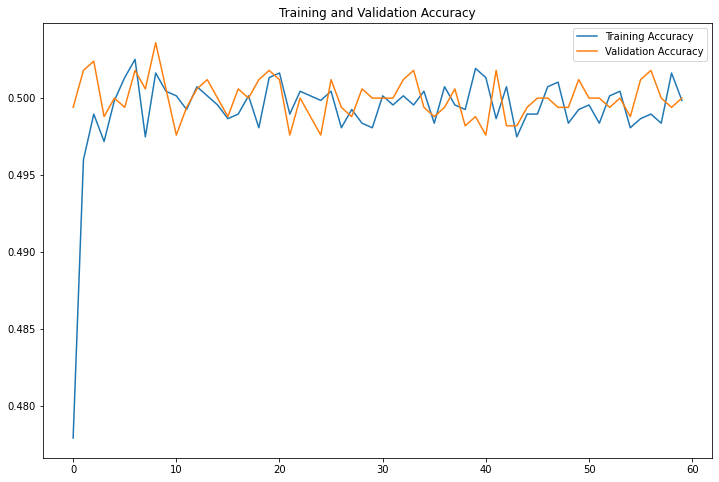

In [ ]:
# plot training and validation accuracy
plt.figure(figsize=(12, 8))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend();

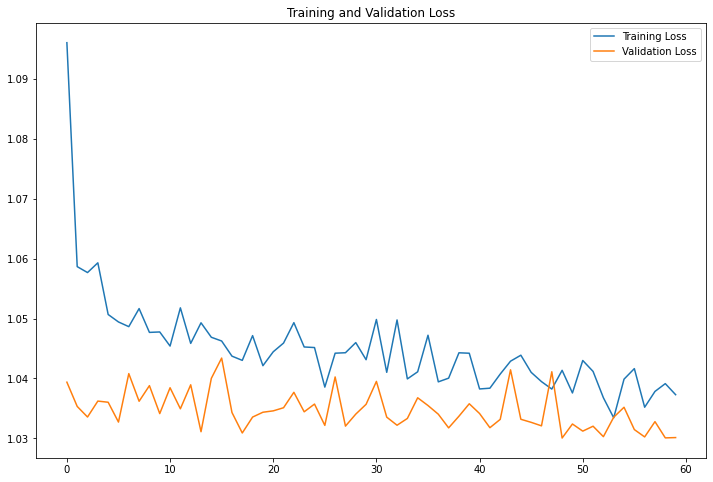

In [ ]:
# plot training and validation loss
plt.figure(figsize=(12, 8))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend();

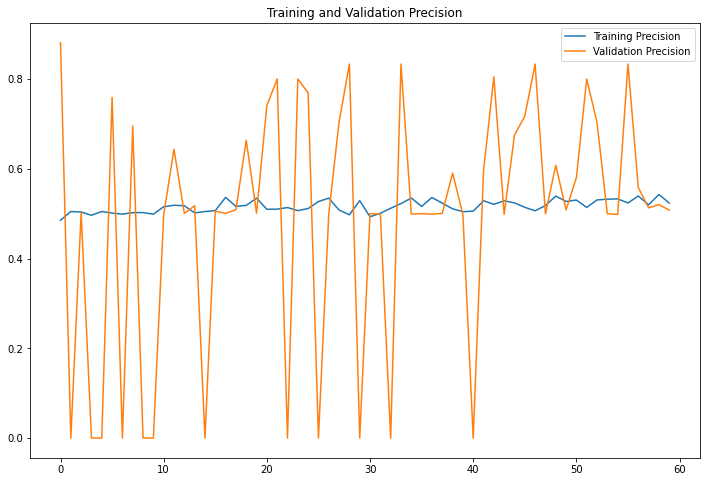

In [ ]:
# plot training and validation precision
plt.figure(figsize=(12, 8))
plt.plot(epochs_range, prec, label='Training Precision')
plt.plot(epochs_range, val_prec, label='Validation Precision')
plt.title('Training and Validation Precision')
plt.legend();

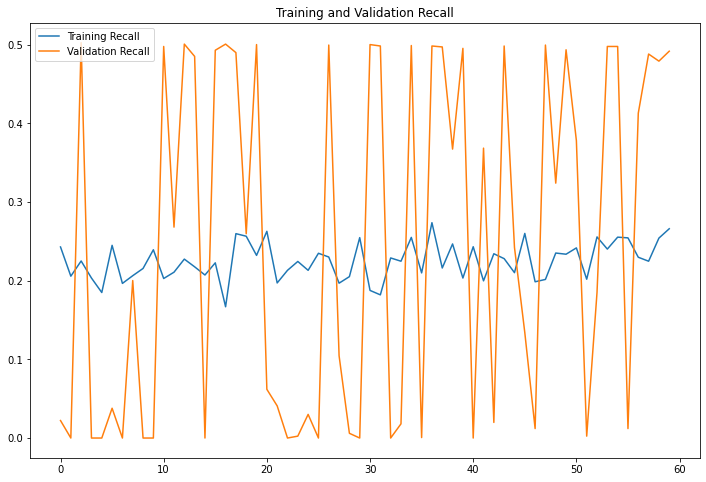

In [ ]:
# plot training and validation recall
plt.figure(figsize=(12, 8))
plt.plot(epochs_range, recall, label='Training Recall')
plt.plot(epochs_range, val_recall, label='Validation Recall')
plt.title('Training and Validation Recall')
plt.legend();

Based on the charts this model stops improving after about 17 or so epochs. This model's best accuracy, precision, and recall are all about 50%. This model performs the worst out of all models essentially doing as well as the baseline model.

In [ ]:
# save best mobile net v3 model
model.save('/content/drive/MyDrive/project-5/mobilenetv3-model.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
